# Feature engineering...

## For each feature, construct a dictionary mapping categories to click rates , sum of clicks, or count of clicks or bin number of these click metrics. Replace the feature by its mapping. This was a rabbit hole -- it did not lead to improved prediction. 



In [1]:
######################################################
# Avazu competitition using pandas and sklearn library

import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline
import category_encoders as ce
import copy
import pickle
import gc
#import xlearn as xl
from datetime import datetime, date, time
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss
from sklearn.feature_extraction import FeatureHasher
from sklearn import preprocessing 
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from xgboost import XGBClassifier #note: activate the xgboost environment
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
import scikitplot as skplt
########################
# set control parameters

important_columns = []

# set the number of hash bins for FeatureHasher
# 2**27 gets same result as 2**29, 2**30 produces memory error
n_features = 2**20
# n_features = 2**27 #increase when including bilinear features

# categorical encoding method: 'bin_number', 'encode', 'click_rate', 'hash'
categorical_method='hash'

# chunk_size
chunk_size= 1e5

# file and folder paths
#train_file = 'train.csv'
train_file = 'train_shuffled.csv' # !!!!! no header
model_path = './'

# number of training examples to read
n_rows = chunk_size

# Fraction of training set to use for dev
train_frac = 0.8

# seed for random generator
seed = 99

# set start time
start = datetime.now()

# column names in original data file
header =    ['id','click','hour','C1','banner_pos','site_id','site_domain',\
                    'site_category','app_id','app_domain','app_category','device_id',\
                    'device_ip','device_model','device_type','device_conn_type','C14',\
                    'C15','C16','C17','C18','C19','C20','C21']
# list of regularization hyperparameter values for cv
# C_range = [1]

# select classifier
classifier = 'lgb'

# maximum number of bins for lightgbm
n_bins_max = 1e7

# minimum number of impressions for category click rate to be measured
min_impression_count = 0

# neg to pos class ratio = sum(y_train==0)/sum(y_train==1)
scale_pos_weight = 1

# Option to tune the hyperparameters by cross-validation
cv_tune = False

# option to archive model
archive_model = True

# option to add features based on bin number of counts
add_bin_number_features = False

# option to add bilinear features
add_bilinear_features = True

# option to calibrate probs
calibrate_probs = False


##########################################################
# read data from randomly shuffled data file and preprocess

# test and dev sets -- use header = None for scrambled train file, header = 0 for original
# number of lines to skip
skip_rows=0
rawdata = pd.read_table(train_file, sep=',', chunksize=chunk_size, names=header,\
                        header=None,skiprows = skip_rows,nrows = n_rows).get_chunk()

# for probability calibration
# number of lines to skip
skip_rows=int(n_rows)
calibdata = pd.read_table(train_file, sep=',', chunksize=chunk_size, names=header,\
                        header=None,skiprows = skip_rows,nrows = n_rows).get_chunk()

# convert to str
rawdata=rawdata.astype(str) 
calibdata=calibdata.astype(str) 

#######################################################
# Prepare new dev and test data sets from training data

# training labels
y_train = rawdata['click'].values

# split into dev and test
y_dev = y_train[:int(train_frac*n_rows)]
y_test = y_train[int(train_frac*n_rows):]

# data to use for probability calibration
y_calib = calibdata['click'].values

# list of features
current_features = header

# feature cardinalities
cardinality = {}
for col in current_features:
    cardinality[col]=len(rawdata[col].unique())
print(cardinality)


############################################
# features to drop 

# list of features to drop (features with more than 1000 categories)
#features_to_drop = ['device_id','device_ip', 'device_model', 'site_id', 'site_domain', 'app_id', 'C14']
features_to_drop = []
features_to_drop.append('click')
features_to_drop.append('id')

# drop features from list
for item in features_to_drop:
    current_features.remove(item)

print('current features: ',current_features)


##############################################
# add features

# add hour and dayoftheweek features
add_engineered_datetime_features = True
if(add_engineered_datetime_features): 
    print('adding engineered datetime features...')
    rawdata['hour']=rawdata['hour'].map(lambda x: datetime.strptime(str(x),"%y%m%d%H"))
    rawdata['dayoftheweek']=rawdata['hour'].map(lambda x:  x.weekday()).astype(str)
    rawdata['hour']=rawdata['hour'].map(lambda x:  x.hour).astype(str)

    calibdata['hour']=calibdata['hour'].map(lambda x: datetime.strptime(str(x),"%y%m%d%H"))
    calibdata['dayoftheweek']=calibdata['hour'].map(lambda x:  x.weekday()).astype(str)
    calibdata['hour']=calibdata['hour'].map(lambda x:  x.hour).astype(str)
    
    # Convert to str
    #calibdata['hour']=calibdata['hour'].astype(str)
    #calibdata['dayoftheweek']=calibdata['dayoftheweek'].astype(str)
    #rawdata['hour']=calibdata['hour'].astype(str)
    #rawdata['dayoftheweek']=rawdata['dayoftheweek'].astype(str)
    
    # add dayofweek to current_features
    current_features.append('dayoftheweek')
 
    
# option to add bilinear features   
if(add_bilinear_features):

    # initialize timer
    start_time = datetime.now()
    print('adding bilinear features...')
    columns = current_features
    count = 0
    combined_features = []
    bilinear_features = []
     
    for col_1 in columns:
        for col_2 in columns:
            col_12 = "_".join([col_1,col_2])
            col_21 = "_".join([col_2,col_1])
            # update list of combined features
            combined_features.append(col_21)
            
            # add bilinear feature
            # filter out duplicates (order of col_1 and col_2 doesn't matter,
            #     and col_12 when col1 == col2 is not a new feature)
            if col_1 != col_2 and col_12 not in combined_features:
                count+=1
                rawdata[col_12] = rawdata[[col_1,col_2]].apply(lambda x: "".join(x),axis=1)
                calibdata[col_12] = calibdata[[col_1,col_2]].apply(lambda x: "".join(x),axis=1)
                # update bilinear_features
                bilinear_features.append(col_12)
                print('bilinear feature #',count,col_1,col_2,col_12)        
                print('\nelapsed time ',datetime.now()-start_time)
    
    # update current features
    current_features = current_features + bilinear_features
    # Elapsed time for creating bilinear features
    print('time to create bilinear features ',datetime.now()-start_time)
        

#####################################################
# build a preprocessing pipeline for feature hashing
preproc = Pipeline([('fh',FeatureHasher( n_features=n_features,input_type='string'))])

#####################################################
# function to create ordered bin number feature
def encode_to_ordered_bin_number(df_pred,df_input,feature):
    
    '''
    function to map a feature's categories to the ordered bin number of the chosen agg_func
    inputs:
        data frame
        feature whose categories are to be mapped
        
    outputs:
        transformed column
    '''

    # sorted device_type counts (ascending order)
    sorted_counts = df_input.groupby(feature)['hour'].count().sort_values(inplace=False)

    # build dictionary that maps the device_type to the bin number of the sorted counts
    #     of the input dataframe
    feature_dict = dict()
    feature_dict=dict( zip( sorted_counts.index.tolist(), range(len(sorted_counts)) ) )

    # map the feature categories to the bin number of the sorted counts
    # map unknown category to feature_dict['unk'], or to last caategory
    return df_pred[feature].map(lambda x: feature_dict[x] \
                                if x in feature_dict.keys() else feature_dict[0])
    #                           if x in feature_dict.keys() else feature_dict['unk'])

############################
# features matrix


# dev set consists of first train_frac of training set
df_dev = rawdata.iloc[:int(train_frac*n_rows),:].copy(deep=True)
df_dev = df_dev[current_features]


# calib set consists of first train_frac of training set
# for probability calibration
df_calib = calibdata.copy(deep=True)
df_calib = df_calib[current_features]

# test set for model evaluation: remaining (1-train_frac) of training set
df_test = rawdata.iloc[int(train_frac*n_rows):,:].copy(deep=True)
df_test = df_test[current_features]

##############################################
# encode features

# LabelEncoder
if(categorical_method == 'encode'):
    print('Encoding features numerically...')
    encoder = preprocessing.LabelEncoder()
    df_dev = df_dev.apply(encoder.fit_transform)
    # process df_calib for probability calibration
    df_calib = df_calib.apply(encoder.fit_transform)

# map to bin number of counts   
elif(categorical_method == 'bin_number'):
    
    print('Encoding features by bin number...')
    for feature in current_features:
        new_feature = feature + '_bin'
        df_dev[new_feature] = encode_to_ordered_bin_number(df_dev,df_dev,feature)
        df_calib[new_feature] = encode_to_ordered_bin_number(df_calib,df_calib,feature)
    # Encode all features
    print('Encoding features numerically...')
    encoder = preprocessing.LabelEncoder()
    df_dev = df_dev.apply(encoder.fit_transform)
    # process df_calib for probability calibration
    df_calib = df_calib.apply(encoder.fit_transform)
        
# map feature categories to their corresponding click rates
# Note that all categories with click rate of zero will be mapped into the same 
# (new) category!
elif(categorical_method == 'click_rate'):

    print('Encoding features by click rate...')
    category_dict = {}
    for col in current_features:
        
        # get mean category click rates
        category_click_rates = df_dev.groupby(col)['click'].mean()
        
        # make a dictionary mapping category values to click rates
        category_dict[col] = {category : \
            category_click_rates[category] \
                for category in category_click_rates.index}
        
        # new dataframe of click rates for selected features
        df_dev[col] = df_dev[col].map(category_dict[col])
        



# encode features test set
if(categorical_method == 'encode'):
    print('Encoding features numerically...')
    encoder = preprocessing.LabelEncoder()
    df_test = df_test.apply(encoder.fit_transform)

elif(categorical_method == 'bin_number'):
    print('Encoding features by bin number...')
    for feature in current_features:
        new_feature = feature + '_bin'
        df_test[new_feature] = encode_to_ordered_bin_number(df_test,df_test,feature)
    # Encode all features
    print('Encoding features numerically...')
    encoder = preprocessing.LabelEncoder()
    df_test = df_test.apply(encoder.fit_transform)

elif(categorical_method == 'click_rate'):

    # make a copy of the category_dict for mapping test features
    test_category_dict = copy.deepcopy(category_dict)
    
    # map columns of test data set using the dictionary from the dev set
    unseen_category_count = {}
    for col in current_features:

        # list of test categories for this feature 
        test_categories = df_test[col].unique().tolist()

        # If a feature category in the test set was not seen in the dev set, then
        # map this category to the median click rate of this feature in the dev set.
        # !!!!! try using zero instead of median
        count = 0
        for tc in test_categories:
            if tc not in category_dict[col].keys():
                count+=1

                # add the mapping for this category to the test_category_dict for this column
                test_category_dict[col][tc] = 0

        # record the number of examples with new categories for this feature
        #     i.e. with categories that were not seen in the dev data
        unseen_category_count[col] = count
        print(col,' has ',count,' examples with categories that were not encountered in the dev set\n')

        # map the categories to the click rate seen in the test_dev set for this feature
        df_test[col] = df_test[col].map(category_dict[col])



    
# Option to add new features based on bin number of counts
if(add_bin_number_features):

    # list of new features to be added
    new_features = []
    for feature in current_features:
        new_feature = feature + '_bin'
        new_features.append(new_feature)
    
    
    for feature in current_features:
        new_feature = feature + '_bin'
        df_dev[new_feature] = encode_to_ordered_bin_number(df_dev,df_dev,feature)
        df_calib[new_feature] = encode_to_ordered_bin_number(df_calib,df_calib,feature)
        df_test[new_feature] = encode_to_ordered_bin_number(df_test,df_test,feature)

    # update list of current_features
    current_features = current_features + new_features
        
# features matrix
X_dev = np.asarray(df_dev)
X_calib = np.asarray(df_calib)
X_test = np.asarray(df_test)

if(categorical_method == 'hash'):

    # Convert to str
    #df_dev=df_dev.astype(str)   
    #df_calib=df_calib.astype(str)   
    #df_test=df_test.astype(str)
    
    # features array
    X_dev = np.asarray(df_dev)
    X_calib = np.asarray(df_calib)
    X_test = np.asarray(df_test)
        

    # hash all features, create features matrix
    print('Hashing current features...')        
    X_dev = preproc.fit_transform(X_dev)
    X_calib = preproc.fit_transform(X_calib)
    X_test = preproc.fit_transform(X_test)



# scale the features -- makes no difference...
scale = False
if(scale==True):
    scaler = StandardScaler()
    scaler.fit(X_dev)
    X_dev = scaler.transform(X_dev)
    X_test = scaler.transform(X_test)
    X_calib = scaler.transform(X_calib)


{'id': 100000, 'click': 2, 'hour': 240, 'C1': 7, 'banner_pos': 7, 'site_id': 1445, 'site_domain': 1304, 'site_category': 18, 'app_id': 1276, 'app_domain': 91, 'app_category': 21, 'device_id': 17070, 'device_ip': 77873, 'device_model': 3123, 'device_type': 5, 'device_conn_type': 4, 'C14': 1735, 'C15': 8, 'C16': 9, 'C17': 399, 'C18': 4, 'C19': 63, 'C20': 155, 'C21': 60}
current features:  ['hour', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']
adding engineered datetime features...
adding bilinear features...
bilinear feature # 1 hour C1 hour_C1

elapsed time  0:00:05.267301
bilinear feature # 2 hour banner_pos hour_banner_pos

elapsed time  0:00:10.533602
bilinear feature # 3 hour site_id hour_site_id

elapsed time  0:00:15.800903
bilinear feature # 4 hour site_domain hour_site_domain

elapsed time  0

bilinear feature # 91 site_domain device_conn_type site_domain_device_conn_type

elapsed time  0:08:26.752984
bilinear feature # 92 site_domain C14 site_domain_C14

elapsed time  0:08:32.695324
bilinear feature # 93 site_domain C15 site_domain_C15

elapsed time  0:08:38.602662
bilinear feature # 94 site_domain C16 site_domain_C16

elapsed time  0:08:44.539001
bilinear feature # 95 site_domain C17 site_domain_C17

elapsed time  0:08:50.476341
bilinear feature # 96 site_domain C18 site_domain_C18

elapsed time  0:08:56.414681
bilinear feature # 97 site_domain C19 site_domain_C19

elapsed time  0:09:02.370021
bilinear feature # 98 site_domain C20 site_domain_C20

elapsed time  0:09:08.318362
bilinear feature # 99 site_domain C21 site_domain_C21

elapsed time  0:09:14.275702
bilinear feature # 100 site_domain dayoftheweek site_domain_dayoftheweek

elapsed time  0:09:20.223043
bilinear feature # 101 site_category app_id site_category_app_id

elapsed time  0:09:26.231386
bilinear feature # 1

bilinear feature # 182 device_ip C17 device_ip_C17

elapsed time  0:17:56.636580
bilinear feature # 183 device_ip C18 device_ip_C18

elapsed time  0:18:03.242958
bilinear feature # 184 device_ip C19 device_ip_C19

elapsed time  0:18:09.869337
bilinear feature # 185 device_ip C20 device_ip_C20

elapsed time  0:18:16.494715
bilinear feature # 186 device_ip C21 device_ip_C21

elapsed time  0:18:23.153096
bilinear feature # 187 device_ip dayoftheweek device_ip_dayoftheweek

elapsed time  0:18:29.807477
bilinear feature # 188 device_model device_type device_model_device_type

elapsed time  0:18:36.485859
bilinear feature # 189 device_model device_conn_type device_model_device_conn_type

elapsed time  0:18:43.143240
bilinear feature # 190 device_model C14 device_model_C14

elapsed time  0:18:49.859624
bilinear feature # 191 device_model C15 device_model_C15

elapsed time  0:18:56.558007
bilinear feature # 192 device_model C16 device_model_C16

elapsed time  0:19:03.261390
bilinear feature # 

## Build model and evaluate on test set

elapsed time:  0:00:21.334220
The model is trained on the full development set  80.0  % of the training samples
The scores are computed on the full evaluation set  19.999999999999996  % of the training samples



C:\Users\jcat\Anaconda3\envs\xgboost\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



logloss for test data set:  0.40772619333989796

Relative Information Gain --  0.10882570196784747


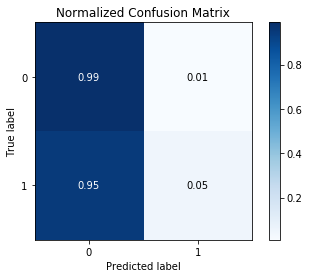

In [15]:
# set start time
start_time = datetime.now()

# set model parameters
params = {}
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['feature_fraction'] = 0.5
params['bagging_fraction'] = 0.5
params['bagging_freq'] = 1
params['num_threads'] = 4 # number of CPUs
params['is_unbalance'] = False
params['max_bin'] = n_features
params['importance_type'] = 'gain' 
# correction for unbalanced data makes things worse!
params['is_unbalance'] = False
params['scale_pos_weight'] = 1
params['min_data_in_leaf'] = 30
params['max_depth'] = 20 
params['learning_rate'] = 0.1
params['min_data_per_group'] = 30
params['num_leaves'] = 30
params['regression_l2'] = 0


# Use lgb.Dataset() interface
## dev_data = lgb.Dataset(X_dev, label=y_dev,categorical_feature=None)
## test_data = lgb.Dataset(X_test, label=y_test,reference=dev_data,categorical_feature=None)
## clf = lgb.train(params, dev_data, valid_sets=[test_data])


# Use LGBMClassifier
# build model using dev set
clf = LGBMClassifier(**params,scoring='neg_log_loss')

# fit model on dev set
clf.fit(X_dev, y_dev)
print('elapsed time: ',datetime.now()-start_time)

##print(classification_report(y_true, y_pred,target_names=['class0','class1']))
# ??? sklearn.metrics.classification_report throws error: 
#     C:\Users\jcat\Anaconda3\envs\xgboost\lib\site-packages\sklearn\preprocessing\label.py:151: 
#     DeprecationWarning: The truth value of an empty array is ambiguous. 
#     Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

# importance_type = 'gain'
if not categorical_method == 'hash':
    print('Feature importances for importance type gain -- ')
    importances = clf.feature_importances_
    feat_imp = pd.Series(importances,index=current_features)
    feat_imp.plot(kind='barh', figsize=(8,10))

# predict on test set
print('The model is trained on the full development set ',100*train_frac,' % of the training samples')
print('The scores are computed on the full evaluation set ',100*(1-train_frac),' % of the training samples\n')
y_true, y_pred = y_test, clf.predict(X_test)

# confusion matrix
skplt.metrics.plot_confusion_matrix(y_true, y_pred, normalize=True)

# predict targets for test set and compute log_loss metric
y_prob = clf.predict_proba(X_test)[:,1]
logloss_test = log_loss(y_test, y_prob)
print('\nlogloss for test data set: ',logloss_test)

# mean click rate
prob_click = rawdata.click.astype(int).mean()

# RIG = relative information gain
NE = -prob_click*np.log(prob_click) -(1-prob_click)*np.log(1-prob_click)
print('\nRelative Information Gain -- ',1-logloss_test/NE)

#########################
# probability calibration
if calibrate_probs:
    #clf_calib = CalibratedClassifierCV(clf, cv=10, method='isotonic')
    clf_calib = CalibratedClassifierCV(clf, cv=10, method='sigmoid')
    clf_calib.fit(X_calib, y_calib)
    probas_calib = clf_calib.predict_proba(X_test)[:,1]
    calib_score = log_loss(y_test, probas_calib)
    print('\ncalibrated logloss -- ', calib_score)

